# Cifar10 Pipeline

## Prequisites

#### Following dependent packages needs to be installed before running the build script

1. kfp - `! pip install kfp`
2. docker - should be logged in using docker login
3. yq - install using snap - https://github.com/mikefarah/yq
4. jq - v1.6 - https://stedolan.github.io/jq/download/

#### ./build.sh takes two arguments

1. path to example - For ex: examples/cifar10
2. dockerhub username - For ex: shrinathsuresh


## Install packages

In [50]:
!pip install captum torchvision matplotlib pillow flask flask_compress numpy minio pytorch_lightning

**Make sure the current working directory is "pytorch_pipeline"**

In [2]:
import os
os.getcwd()

'/home/ubuntu/Repositories/fb/pytorch-pipeline/pytorch_pipeline'

## Generate Pipeline file

In [51]:
! ./build.sh examples/cifar10 docker-username

## At the end of this step - pytorch_cifar10.yaml file will be generated

In [4]:
import kfp
import json
import os
from PIL import Image
from kfp import components
from kfp.components import load_component_from_file, load_component_from_url
from kfp import dsl
from kfp import compiler
from pathlib import Path

kfp.__version__

'1.6.2'

# Enter your KFP URL and the token from the cookie
[Use this extension on chrome to get token]( https://chrome.google.com/webstore/detail/editthiscookie/fngmhnnpilhplaeedifhccceomclgfbg?hl=en)
![image.png](image.png)

## Set Pipeline URL, Cookie, Experiment and Namespac

In [5]:
# KFP_URL='istio-ingressgateway.istio-system.svc.cluster.local'
KFP_URL='http://localhost:8080'
COOKIE="Add Cookie here"
AUTH="authservice_session="+COOKIE
NAMESPACE="kubeflow-user-example-com"
EXPERIMENT="Default"

## Set Log bucket and Tensorboard Image

In [6]:
MINIO_ENDPOINT="http://minio-service.kubeflow:9000"
LOG_BUCKET="mlpipeline"
TENSORBOARD_IMAGE="jagadeeshj/tb_plugin:v1.8"

## Set Inference parameters

In [7]:
MODEL_NAME="cifar10"
DEPLOY_NAME="torchserve"
ISVC_NAME=DEPLOY_NAME+"."+NAMESPACE+"."+"example.com"
INFERENCE_URL="http://istio-ingressgateway.istio-system.svc.cluster.local"
INPUT_REQUEST="https://kubeflow-dataset.s3.us-east-2.amazonaws.com/cifar10_input/input.json"

## Create KFP Client and create an experiment

In [8]:
client = kfp.Client(host=KFP_URL+"/pipeline", cookies=AUTH)
client.create_experiment(name=EXPERIMENT, namespace=NAMESPACE)
experiments = client.list_experiments(namespace=NAMESPACE)
my_experiment = experiments.experiments[0]
my_experiment

{'created_at': datetime.datetime(2021, 4, 22, 8, 44, 39, tzinfo=tzutc()),
 'description': None,
 'id': 'aac96a63-616e-4d88-9334-6ca8df2bb956',
 'name': 'Default',
 'resource_references': [{'key': {'id': 'kubeflow-user-example-com',
                                  'type': 'NAMESPACE'},
                          'name': None,
                          'relationship': 'OWNER'}],
 'storage_state': 'STORAGESTATE_AVAILABLE'}

## Pipeline params

In [9]:
pipeline_params = {
    "minio_endpoint" : MINIO_ENDPOINT,
    "tf_image" : TENSORBOARD_IMAGE,
    "log_bucket" : LOG_BUCKET,
    "input_req" : INPUT_REQUEST,
    "cookie" :  COOKIE,
    "ingress_gateway" : INFERENCE_URL,
    "isvc_name" : ISVC_NAME,
    "deploy" : DEPLOY_NAME,
    "model" : MODEL_NAME,
    "namespace" : NAMESPACE,
}

## Click on Run Details for navigating to pipeline

In [10]:
run_name = 'pytorch-cifar10'
# Execute pipeline
run = client.run_pipeline(my_experiment.id, run_name, "pytorch_cifar10.yaml", pipeline_params)

## Get Inference service name

In [11]:
INFERENCE_SERVICE_LIST = ! kubectl get isvc $DEPLOY_NAME -n kubeflow-user-example-com -o json | jq .status.url | tr -d '"'| cut -d "/" -f 3
INFERENCE_SERVICE_NAME = INFERENCE_SERVICE_LIST[0]
INFERENCE_SERVICE_NAME

'torchserve.kubeflow-user-example-com.example.com'

In [52]:
!curl -v -H "Host: $INFERENCE_SERVICE_NAME" -H "Cookie: $AUTH" "$KFP_URL/v1/models/$MODEL_NAME:predict" -d @./examples/cifar10/input.json > cifar10_prediction_output.json

In [13]:
! cat cifar10_prediction_output.json

{"predictions": [{"9": 0.6024335622787476, "1": 0.34845903515815735, "0": 0.023012220859527588, "6": 0.015642639249563217, "2": 0.0028355871327221394}]}

In [53]:
!curl -v -H "Host: $INFERENCE_SERVICE_NAME" -H "Cookie: $AUTH" "$KFP_URL/v1/models/$MODEL_NAME:explain" -d @./examples/cifar10/input.json > cifar10_explanation_output.json

In [17]:
#! head -5 cifar10_explanation_output.json

In [23]:
import json
import numpy as np
import os
import logging

from PIL import Image
import torchvision.transforms as transforms

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

In [24]:
explainations_json = json.loads(open("./cifar10_explanation_output.json", "r").read())
attributions = explainations_json['explanations']
attributions = np.array(attributions)
attributions = attributions.reshape((224,224,3))

In [25]:
prediction_json = json.loads(open("./cifar10_prediction_output.json", "r").read())
prediction_json["predictions"][0]

{'9': 0.6024335622787476,
 '1': 0.34845903515815735,
 '0': 0.023012220859527588,
 '6': 0.015642639249563217,
 '2': 0.0028355871327221394}

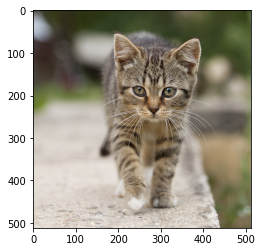

In [26]:
#Read the test image
test_img = Image.open('./examples/cifar10/kitten.png')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()


In [27]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [28]:
labels_path = './examples/cifar10/class_mapping.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data) 
list(map(lambda k: idx_to_labels[k], idx_to_labels.keys()))

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

#### Update minio creds in the below cell

In [37]:
from minio import Minio
from kubernetes import client, config
import base64

config.load_kube_config()
v1 = client.CoreV1Api()
sec = v1.read_namespaced_secret("mlpipeline-minio-artifact", "kubeflow-user-example-com").data
minio_accesskey = base64.b64decode(sec["accesskey"]).decode('UTF-8')
minio_secretkey = base64.b64decode(sec["secretkey"]).decode('UTF-8')


minio_config = {
            "HOST": "localhost:9000",
            "ACCESS_KEY": minio_accesskey,
            "SECRET_KEY": minio_secretkey,
            "BUCKET": "mlpipeline",
            "FOLDER": "checkpoint_dir/cifar10"}

def _initiate_minio_client(minio_config):
        minio_host = minio_config["HOST"]
        access_key = minio_config["ACCESS_KEY"]
        secret_key = minio_config["SECRET_KEY"]
        client = Minio(minio_host, access_key=access_key, secret_key=secret_key, secure=False)
        return client

client= _initiate_minio_client(minio_config)
client

In [38]:
def download_artifact_from_minio(folder: str, artifact: str):
        artifact_name = artifact.split("/")[-1]
        result = client.fget_object(
            minio_config["BUCKET"],
            os.path.join(folder, artifact_name),
            artifact,
        )
        print(result)      


In [39]:
download_artifact_from_minio(minio_config["FOLDER"],"resnet.pth")
print("[INFO] Downloaded the Model Pth File.....")
download_artifact_from_minio(minio_config["FOLDER"],"cifar10_train.py")
print("[INFO] Downloaded the Model Classifier File.....")

[INFO] Downloaded the Model Pth File.....
[INFO] Downloaded the Model Classifier File.....


In [54]:
from cifar10_train import CIFAR10Classifier
model = CIFAR10Classifier()
model_pt_path ="./resnet.pth"
model.load_state_dict(torch.load(model_pt_path,map_location=torch.device('cpu')))
model.eval()

#### Captum Vis and Insights

In [43]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()

predicted_label = idx_to_labels[str(pred_label_idx.squeeze_().item())]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: truck ( 0.5510547161102295 )


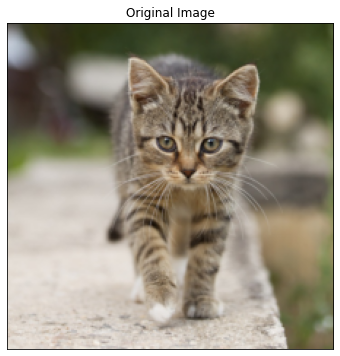

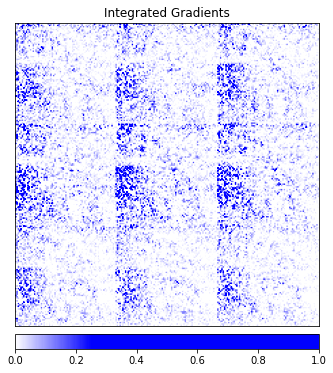

In [44]:
# Show the original image for comparison
#np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0))
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(attributions,
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

In [45]:
imgs = ['./examples/cifar10/kitten.png',"./examples/cifar10/horse.png"]

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.squeeze_().item())]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: truck / 9  ( 0.5510547161102295 )
Predicted: car / 1  ( 0.6891049146652222 )


In [46]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    i.requires_grad = True
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[3,7])]
)

In [47]:
visualizer.render(debug =True)

CaptumInsights(insights_config={'classes': ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sh…

Output()

In [48]:
visualizer.serve(debug=True,port =6080)


Fetch data and view Captum Insights at http://localhost:6080/



INFO:werkzeug: * Debugger PIN: 884-986-344


6080

INFO:werkzeug: * Running on http://127.0.0.1:6080/ (Press CTRL+C to quit)


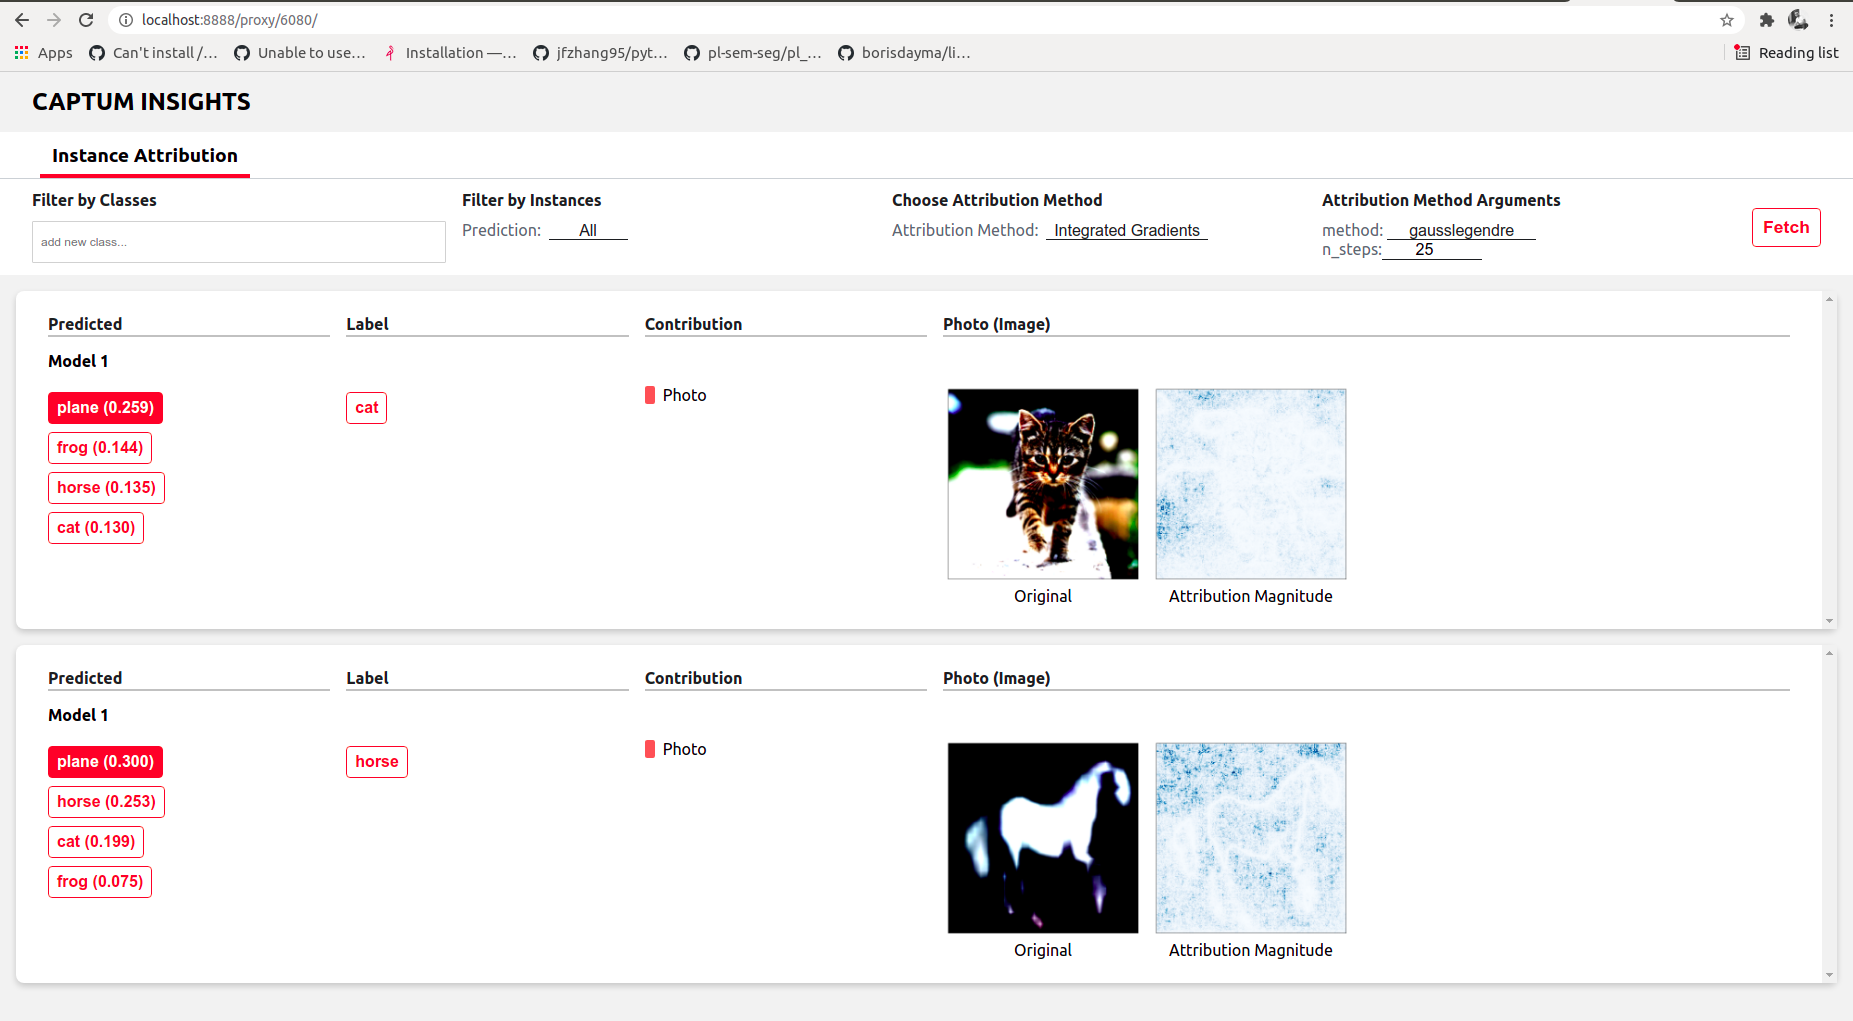

In [49]:
import IPython.display
IPython.display.Image(filename="./examples/cifar10/CIFAR10_Captum_Insights.png")

## Clean up
### Delete Viewers, Inference Services and Completed pods

In [55]:
! kubectl delete --all viewers -n $NAMESPACE

In [56]:
! kubectl delete --all isvc -n $NAMESPACE

In [ ]:
! kubectl delete pod --field-selector=status.phase==Succeeded -n $NAMESPACE